Прямая задача

ПРЯМАЯ ЗАДАЧА: ДОПЛЕР С УЧЁТОМ RAMP (ИСПРАВЛЕННАЯ ВЕРСИЯ)
  ✓ naif0010.tls
  ✗ Отсутствует: pck00010.tpc
  ✓ earth_720101_070426.bpc
  ✓ de442s.bsp
  ✓ mgs_ab1.bsp
  ✓ dsnstns.bsp
Загружено SPICE kernels: 5

[1] Загрузка данных...
  Начальное состояние КА относительно Марса:
    Положение: (34152.1, 18590.0, -32821.5) км
    |r| = 50884.3 км
    |v| = 0.5268 км/с
Загрузка доплеровских данных...
  Загружено записей: 2168
  Записей с RAMP данными: 2139 (98.7%)
  Записей без RAMP данных: 29
  После фильтрации: 2139 записей
  Выделено сессий: 6

  Частота передатчика (RAMP):
    Диапазон: 7.164821 - 7.164869 ГГц
    Среднее:  7.164842 ГГц

  Опорная частота (ref_freq):
    Значение: 70205.932 МГц = 70.205932 ГГц

[2] Интегрирование орбиты...
  Начало: 1997-09-19T00:00:30
  Длительность: 2 суток, шаг: 60 сек
    Шаг 0/2880 (0.0%)
    Шаг 100/2880 (3.5%)
    Шаг 200/2880 (6.9%)
    Шаг 300/2880 (10.4%)
    Шаг 400/2880 (13.9%)
    Шаг 500/2880 (17.4%)
    Шаг 600/2880 (20.8%)
    Шаг 700/288

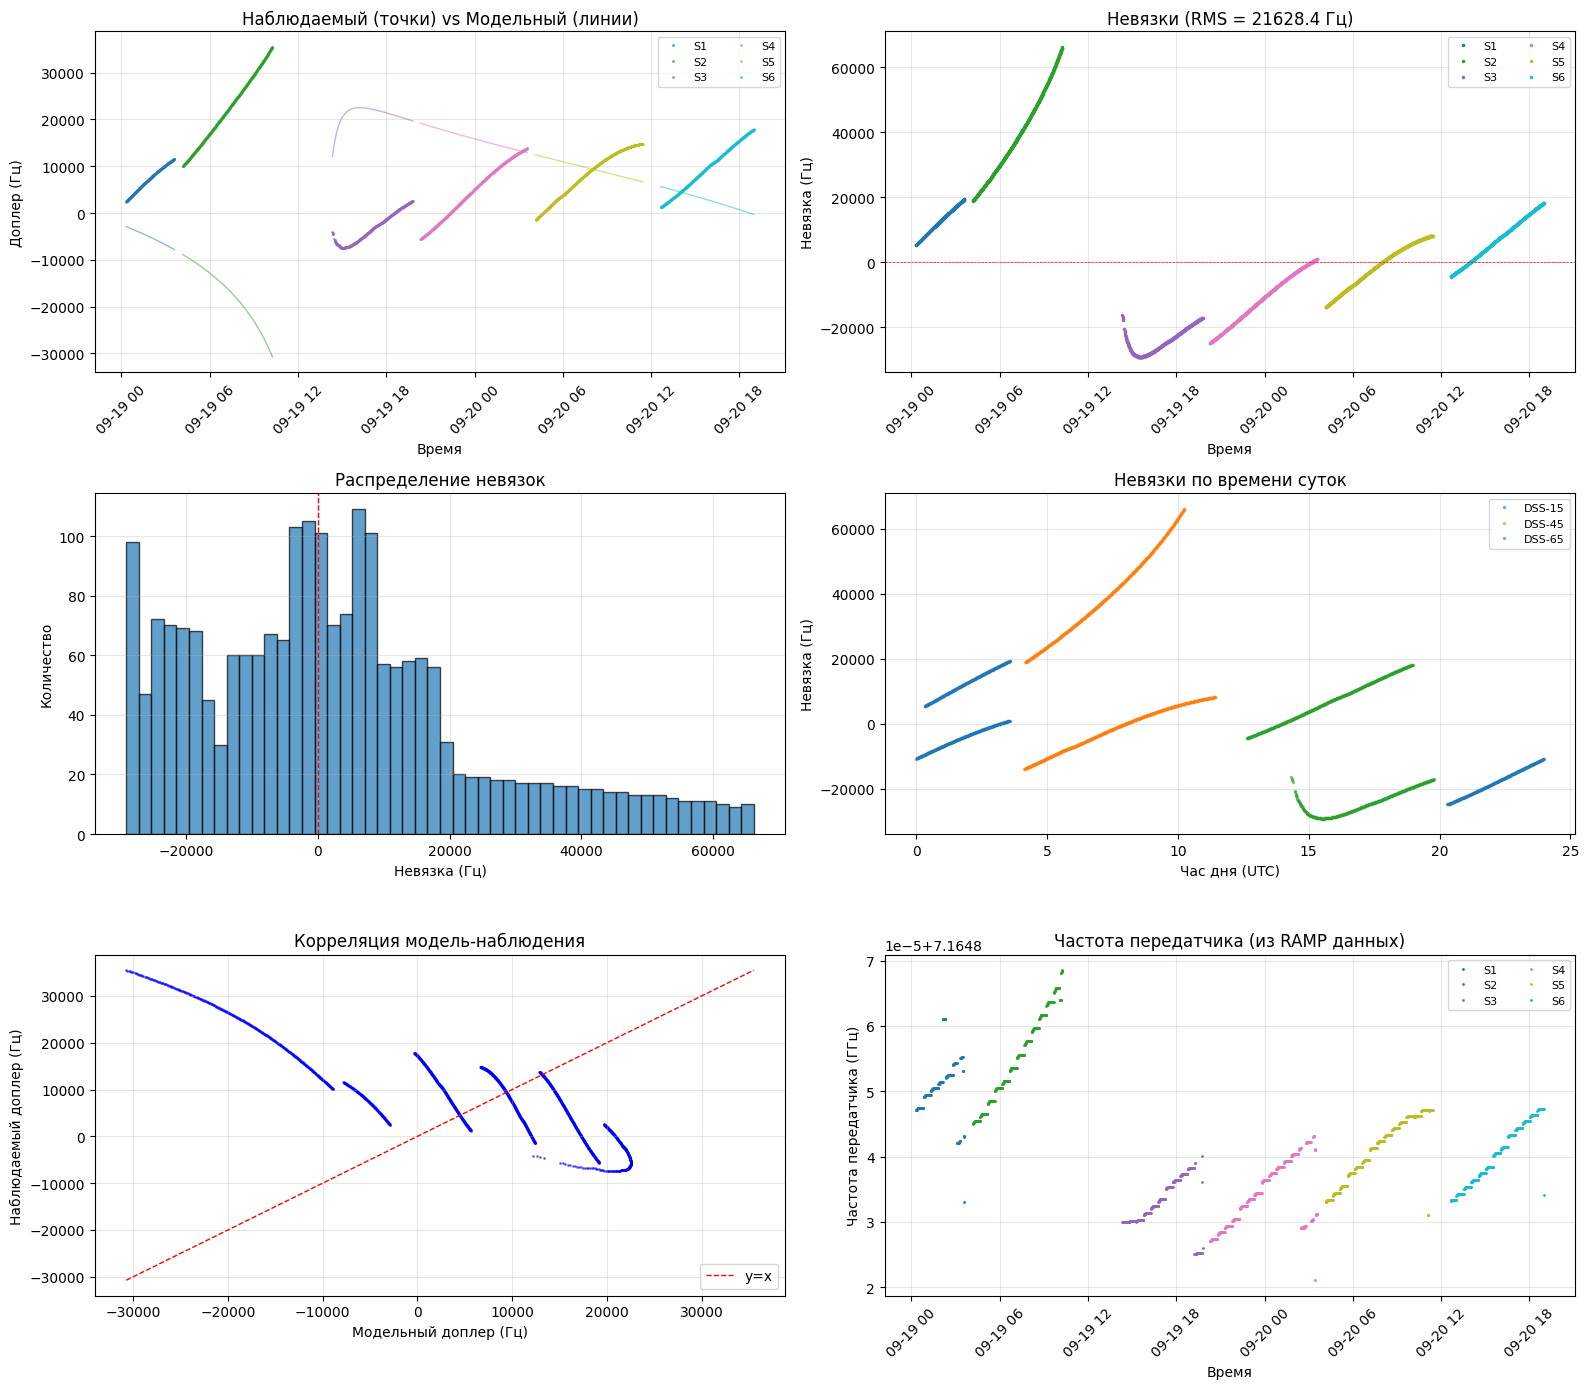


Результаты сохранены в ./output_data/doppler_results_corrected.csv

Расчёт завершён успешно!


In [ ]:
"""
Прямая задача: работа с вариациями доплера с учётом RAMP. 

Ключевая идея:
- DSN ramping компенсирует предсказанный доплер от движения Марс-Земля
- RAMP данные содержат реальную частоту передатчика в каждый момент
- Используем interpolated_tx_freq_hz для корректного расчёта доплера
"""

import numpy as np
import pandas as pd
import spiceypy as spice
from scipy.interpolate import interp1d
from scipy.signal import detrend
import os
import matplotlib.pyplot as plt
from datetime import datetime

# =============================================================================
# КОНСТАНТЫ
# =============================================================================

KERNEL_DIR = './spice_data/'
GEOMETRY_FILE = './output_data/mgs_geometry.csv'
DOPPLER_FILE = './output_data/mgs_doppler_with_ramp_filled.csv'
OUTPUT_DIR = './output_data/'

GM = {
    'sun':        132712440041.93938,
    'mercury':   22031.868551,
    'venus':     324858.592,
    'earth':     398600.435507,
    'moon':      4902.800118,
    'mars':      42828.375816,
    'jupiter':   126712764.100,
    'saturn':    37940584.841,
    'uranus':    5794556.400,
    'neptune':   6836527.100,
}

C_LIGHT = 299792.458  # km/s
MARS_RE = 3396.19     # km

# КРИТИЧЕСКИЕ ИСПРАВЛЕНИЯ:
# 1. MGS X-band коэффициент транспондера
M2_XBAND = 240.0 / 221.0  # ПРАВИЛЬНЫЙ для MGS X-band

# 2. В ваших данных частота ~7.1648 ГГц - это UPLINK (передатчик)
# Downlink будет: f_down = f_up * M2 = ~7.1648 * 1.08597 ≈ 7.779 ГГц
# Но в ODF ref_freq_mhz = 70205.932 МГц = 70.205932 ГГц - это промежуточная частота!

DSN_STATIONS = {
    # 14: {'lon': -116.889, 'lat': 35.426, 'height': 1001.39},
    15: {'lon': -116.887, 'lat': 35.422, 'height': 973.21},
    # 43: {'lon': 148.983, 'lat': -35.403, 'height': 688.87},
    45: {'lon': 148.978, 'lat': -35.402, 'height': 674.35},
    # 63: {'lon': -4.249, 'lat': 40.431, 'height': 864.82},
    65: {'lon': -4.255, 'lat': 40.427, 'height': 833.85},
}

# =============================================================================
# SPICE
# =============================================================================

def load_kernels():
    """Загружает SPICE kernels."""
    kernels = [
        'naif0010.tls',        # Leap seconds (обязательно!)
        'pck00010.tpc',        # Базовый PCK - ДОБАВЬТЕ ЭТОТ
        'earth_720101_070426.bpc',
        'de442s.bsp',          # Планетарные эфемериды
        'mgs_ab1.bsp',         # MGS орбита
        'dsnstns.bsp',         # DSN станции
    ]
    
    loaded = []
    for k in kernels:
        path = os.path.join(KERNEL_DIR, k)
        if os.path.exists(path):
            try:
                spice.furnsh(path)
                loaded.append(k)
                print(f"  ✓ {k}")
            except Exception as e:
                print(f"  ✗ {k}: {e}")
        else:
            print(f"  ✗ Отсутствует: {k}")
    
    print(f"Загружено SPICE kernels: {len(loaded)}")
    return loaded

def get_body_state(body_id, t_et):
    """Состояние тела в SSB J2000."""
    state, _ = spice.spkezr(str(body_id), t_et, 'J2000', 'NONE', '0')
    return np.array(state[:3]), np.array(state[3:6])

def get_mars_state(t_et):
    return get_body_state(4, t_et)

def get_earth_state(t_et):
    return get_body_state(3, t_et)

# =============================================================================
# СТАНЦИИ (улучшенная версия через SPICE)
# =============================================================================

def get_dsn_station_position(station_id, t_et, frame='J2000', observer='EARTH'):
    """
    Получает точное положение DSN станции через SPICE.
    
    Args:
        station_id: ID станции (14, 15, 43, 45, 63, 65)
        t_et: эфемеридное время (секунды)
        frame: система координат
        observer: точка отсчёта
        
    Returns:
        np.array: положение [x, y, z] в км
    """
    station_name = f'DSS-{station_id}'
    try:
        state, lt = spice.spkezr(station_name, t_et, frame, 'NONE', observer)
        return np.array(state[:3])
    except Exception as e:
        print(f"Ошибка получения позиции станции {station_name}: {e}")
        # Резервный вариант
        return np.array([0.0, 0.0, 0.0])

# =============================================================================
# ДИНАМИКА
# =============================================================================

def compute_acceleration(t_et, r_sc_mars, v_sc_mars):
    """Ускорение КА относительно Марса."""
    r_mars, v_mars = get_mars_state(t_et)
    r_sc = r_mars + r_sc_mars
    
    a_sc = np.zeros(3)
    a_mars = np.zeros(3)
    
    bodies = [(10, GM['sun']), (1, GM['mercury']), (2, GM['venus']),
              (3, GM['earth']), (301, GM['moon']), (4, GM['mars']),
              (5, GM['jupiter']), (6, GM['saturn']), (7, GM['uranus']),
              (8, GM['neptune'])]
    
    for naif_id, gm in bodies:
        try:
            r_body, _ = get_body_state(naif_id, t_et)
        except:
            continue
        
        # Ускорение КА от тела
        r_to = r_body - r_sc
        d = np.linalg.norm(r_to)
        if d > 1e-10:
            a_sc += gm * r_to / d**3
        
        # Ускорение Марса от тела (кроме самого Марса)
        if naif_id != 4:
            r_to_mars = r_body - r_mars
            d_mars = np.linalg.norm(r_to_mars)
            if d_mars > 1e-10:
                a_mars += gm * r_to_mars / d_mars**3
    
    return a_sc - a_mars

def rk5_step(t, state, dt, accel_func):
    c = [0, 1/5, 3/10, 4/5, 8/9, 1, 1]
    a = [[], [1/5], [3/40, 9/40], [44/45, -56/15, 32/9],
         [19372/6561, -25360/2187, 64448/6561, -212/729],
         [9017/3168, -355/33, 46732/5247, 49/176, -5103/18656],
         [35/384, 0, 500/1113, 125/192, -2187/6784, 11/84]]
    b = [35/384, 0, 500/1113, 125/192, -2187/6784, 11/84, 0]
    
    r, v = state[:3], state[3:6]
    k_r, k_v = [None]*7, [None]*7
    k_r[0], k_v[0] = v, accel_func(t, r, v)
    
    for i in range(1, 7):
        r_t = r + dt * sum(a[i][j] * k_r[j] for j in range(i))
        v_t = v + dt * sum(a[i][j] * k_v[j] for j in range(i))
        k_r[i], k_v[i] = v_t, accel_func(t + c[i]*dt, r_t, v_t)
    
    r_new = r + dt * sum(b[i] * k_r[i] for i in range(7))
    v_new = v + dt * sum(b[i] * k_v[i] for i in range(7))
    return np.concatenate([r_new, v_new])

def integrate_orbit(t0, state0, days=2.0, dt=60.0):
    """Интегрирует орбиту на заданное время."""
    t_end = t0 + days * 86400.0
    n_steps = int((t_end - t0) / dt)
    
    times, states = [t0], [state0.copy()]
    t, state = t0, state0.copy()
    
    for step in range(n_steps):
        state = rk5_step(t, state, dt, compute_acceleration)
        t += dt
        times.append(t)
        states.append(state.copy())
        
        # Прогресс
        if step % 100 == 0:
            print(f"    Шаг {step}/{n_steps} ({step/n_steps*100:.1f}%)")
    
    return {'times': np.array(times), 'states': np.array(states)}

def create_interpolator(orbit_data):
    """Создаёт интерполятор для орбиты."""
    times, states = orbit_data['times'], orbit_data['states']
    
    interp_r = interp1d(times, states[:, :3], axis=0, kind='cubic',
                        fill_value='extrapolate', bounds_error=False)
    interp_v = interp1d(times, states[:, 3:6], axis=0, kind='cubic',
                        fill_value='extrapolate', bounds_error=False)
    
    def get_sc_state(t):
        r_mars, v_mars = get_mars_state(t)
        r_sc = r_mars + interp_r(t)
        v_sc = v_mars + interp_v(t)
        return r_sc, v_sc
    
    return get_sc_state

# =============================================================================
# ДОПЛЕР С УЧЁТОМ RAMP 
# =============================================================================

def solve_light_time_iterative(t3, get_sc_state, station_id, max_iter=10):
    """
    Итеративное решение уравнений светового времени.
    
    Уравнения:
    t2 = t3 - |r_sc(t2) - r_st(t3)| / c
    t1 = t2 - |r_sc(t2) - r_st(t1)| / c
    """
    # Начальное приближение
    t2 = t3
    t1 = t3
    
    for i in range(max_iter):
        # 1. Положение станции в t3
        r_st_t3 = get_dsn_station_position(station_id, t3, 'J2000', 'EARTH')
        r_earth_t3, v_earth_t3 = get_earth_state(t3)
        r_st_ssb_t3 = r_earth_t3 + r_st_t3
        
        # 2. Положение КА в t2
        r_sc_t2, v_sc_t2 = get_sc_state(t2)
        
        # 3. Расстояние t2→t3 и новое t2
        distance_back = np.linalg.norm(r_sc_t2 - r_st_ssb_t3)
        t2_new = t3 - distance_back / C_LIGHT
        
        # 4. Положение станции в t1
        r_st_t1 = get_dsn_station_position(station_id, t1, 'J2000', 'EARTH')
        r_earth_t1, v_earth_t1 = get_earth_state(t1)
        r_st_ssb_t1 = r_earth_t1 + r_st_t1
        
        # 5. Расстояние t1→t2_new
        distance_forward = np.linalg.norm(r_sc_t2 - r_st_ssb_t1)
        t1_new = t2_new - distance_forward / C_LIGHT
        
        # Проверка сходимости
        if abs(t2_new - t2) < 1e-8 and abs(t1_new - t1) < 1e-8:
            return t1_new, t2_new, t3
        
        t1, t2 = t1_new, t2_new
    
    print(f"  Внимание: light-time не сошёлся за {max_iter} итераций")
    return t1, t2, t3

def compute_doppler_corrected(t3, get_sc_state, station_id, f_tx_actual, ref_freq_hz):
    """
    Расчёт доплера для данных ODF.
    
    Ключевые исправления:
    1. Учитываем, что наблюдаемый доплер измеряется относительно ref_freq
    2. Правильно вычисляем масштабный коэффициент
    3. Учитываем только орбитальную компоненту
    """
    # Решаем light-time
    t1, t2, t3 = solve_light_time_iterative(t3, get_sc_state, station_id)
    
    # Получаем положения и скорости
    r_st_t1 = get_dsn_station_position(station_id, t1, 'J2000', 'EARTH')
    r_earth_t1, v_earth_t1 = get_earth_state(t1)
    r_st_ssb_t1 = r_earth_t1 + r_st_t1
    
    r_sc_t2, v_sc_t2 = get_sc_state(t2)
    r_mars_t2, v_mars_t2 = get_mars_state(t2)
    
    r_st_t3 = get_dsn_station_position(station_id, t3, 'J2000', 'EARTH')
    r_earth_t3, v_earth_t3 = get_earth_state(t3)
    r_st_ssb_t3 = r_earth_t3 + r_st_t3
    
    # Векторы направления
    rho_up = r_sc_t2 - r_st_ssb_t1
    rho_dn = r_st_ssb_t3 - r_sc_t2
    
    e_up = rho_up / np.linalg.norm(rho_up)
    e_dn = -rho_dn / np.linalg.norm(rho_dn)  # Направление от КА к станции
    
    # Скорости относительно Марса (орбитальная компонента)
    v_sc_mars = v_sc_t2 - v_mars_t2
    
    # Проекции скорости КА на направления
    v_los_up = np.dot(v_sc_mars, e_up)
    v_los_dn = np.dot(v_sc_mars, e_dn)
    
    # Масштабный коэффициент: частота передатчика / опорная частота
    # В ODF данные нормированы на ref_freq
    scale_factor = f_tx_actual / ref_freq_hz
    
    # Доплер от орбитального движения (two-way)
    # Формула: Δf = -2 * f_ref * (v_los/c) * scale_factor
    # Где v_los - средняя проекция скорости на луч зрения
    v_los_avg = (v_los_up + v_los_dn) / 2
    
    doppler_orbit = -2.0 * ref_freq_hz * (v_los_avg / C_LIGHT) * scale_factor
    
    return {
        'doppler_orbit': doppler_orbit,
        'v_los_avg': v_los_avg,
        'scale_factor': scale_factor,
        't1': t1, 't2': t2, 't3': t3
    }

# =============================================================================
# ЗАГРУЗКА ДАННЫХ
# =============================================================================

def load_initial_conditions(geometry_file):
    """Загружает начальные условия из файла геометрии."""
    df = pd.read_csv(geometry_file)
    df['datetime_utc'] = pd.to_datetime(df['datetime_utc'])
    
    # Берём первую запись как начальное состояние
    row = df.iloc[0]
    
    # Конвертируем время в ET
    t0_et = spice.str2et(row['datetime_utc'].strftime('%Y-%m-%dT%H:%M:%S'))
    
    # Начальное состояние (относительно Марса)
    state0 = np.array([
        row['mgs_x_km'], row['mgs_y_km'], row['mgs_z_km'],
        row['mgs_vx_km_s'], row['mgs_vy_km_s'], row['mgs_vz_km_s'],
    ])
    
    return t0_et, state0, df

def load_doppler_data(doppler_file, require_ramp=True):
    """Загружает и обрабатывает доплеровские данные."""
    print("Загрузка доплеровских данных...")
    df = pd.read_csv(doppler_file)
    df['datetime_utc'] = pd.to_datetime(df['datetime_utc'])
    
    print(f"  Загружено записей: {len(df)}")
    
    # Статистика по RAMP
    if 'ramp_rate_hz_s' in df.columns:
        ramp_valid = df['ramp_rate_hz_s'].notna()
        print(f"  Записей с RAMP данными: {ramp_valid.sum()} ({ramp_valid.sum()/len(df)*100:.1f}%)")
        print(f"  Записей без RAMP данных: {(~ramp_valid).sum()}")
        
        if require_ramp and ramp_valid.any():
            df = df[ramp_valid].copy()
            print(f"  После фильтрации: {len(df)} записей")
    
    # Группировка по сессиям
    df = df.sort_values('datetime_utc')
    df['time_diff'] = df['datetime_utc'].diff().dt.total_seconds()
    
    # Сессия меняется при разрыве > 5 минут или смене станции
    session_change = (df['time_diff'] > 300) | (df['receiving_station_id'] != df['receiving_station_id'].shift())
    df['session_id'] = session_change.cumsum()
    
    print(f"  Выделено сессий: {df['session_id'].nunique()}")
    
    return df

# =============================================================================
# ОСНОВНАЯ ФУНКЦИЯ
# =============================================================================

def main():
    print("="*70)
    print("ПРЯМАЯ ЗАДАЧА: ДОПЛЕР С УЧЁТОМ RAMP (ИСПРАВЛЕННАЯ ВЕРСИЯ)")
    print("="*70)
    
    # 1. Загрузка ядер SPICE
    load_kernels()
    
    # 2. Загрузка начальных условий
    print("\n[1] Загрузка данных...")
    t0_et, state0, geometry_df = load_initial_conditions(GEOMETRY_FILE)
    
    print(f"  Начальное состояние КА относительно Марса:")
    print(f"    Положение: ({state0[0]:.1f}, {state0[1]:.1f}, {state0[2]:.1f}) км")
    print(f"    |r| = {np.linalg.norm(state0[:3]):.1f} км")
    print(f"    |v| = {np.linalg.norm(state0[3:]):.4f} км/с")
    
    # 3. Загрузка доплеровских данных
    doppler_df = load_doppler_data(DOPPLER_FILE, require_ramp=True)
    
    if len(doppler_df) == 0:
        print("Ошибка: нет данных для обработки!")
        return
    
    # Статистика по частотам
    if 'interpolated_tx_freq_hz' in doppler_df.columns:
        f_tx_min = doppler_df['interpolated_tx_freq_hz'].min() / 1e9
        f_tx_max = doppler_df['interpolated_tx_freq_hz'].max() / 1e9
        f_tx_mean = doppler_df['interpolated_tx_freq_hz'].mean() / 1e9
        print(f"\n  Частота передатчика (RAMP):")
        print(f"    Диапазон: {f_tx_min:.6f} - {f_tx_max:.6f} ГГц")
        print(f"    Среднее:  {f_tx_mean:.6f} ГГц")
    
    print(f"\n  Опорная частота (ref_freq):")
    print(f"    Значение: {doppler_df['ref_freq_mhz'].iloc[0]:.3f} МГц = {doppler_df['ref_freq_mhz'].iloc[0]/1e3:.6f} ГГц")
    
    # 4. Интегрирование орбиты
    print("\n[2] Интегрирование орбиты...")
    print(f"  Начало: {spice.et2utc(t0_et, 'ISOC', 0)}")
    print(f"  Длительность: 2 суток, шаг: 60 сек")
    
    orbit_data = integrate_orbit(t0_et, state0, days=2.0, dt=60.0)
    get_sc_state = create_interpolator(orbit_data)
    
    # Статистика орбиты
    radii = np.linalg.norm(orbit_data['states'][:, :3], axis=1)
    print(f"  Радиус орбиты: {radii.min():.1f} - {radii.max():.1f} км")
    
    # 5. Вычисление доплера
    print("\n[3] Вычисление доплера...")
    
    results = []
    
    for idx, row in doppler_df.iterrows():
        try:
            # Время приёма (t3)
            t3 = spice.str2et(row['datetime_utc'].strftime('%Y-%m-%dT%H:%M:%S'))
            station_id = int(row['receiving_station_id'])
            session_id = row['session_id']
            
            # Частоты из данных
            f_tx_actual = row['interpolated_tx_freq_hz']  # Hz
            ref_freq_hz = row['ref_freq_mhz'] * 1e6       # MHz -> Hz
            
            # Вычисление доплера (исправленная формула)
            doppler_result = compute_doppler_corrected(t3, get_sc_state, station_id, 
                                                      f_tx_actual, ref_freq_hz)
            
            # Сохраняем результаты
            results.append({
                'datetime_utc': row['datetime_utc'],
                'et': t3,
                'station_id': station_id,
                'session_id': session_id,
                'observed_hz': row['doppler_hz'],
                'model_hz': doppler_result['doppler_orbit'],
                'residual_hz': row['doppler_hz'] - doppler_result['doppler_orbit'],
                'v_los_km_s': doppler_result['v_los_avg'],
                'scale_factor': doppler_result['scale_factor'],
                'f_tx_ghz': f_tx_actual / 1e9,
                'f_ref_ghz': ref_freq_hz / 1e9,
                'ramp_rate_hz_s': row['ramp_rate_hz_s'] if 'ramp_rate_hz_s' in row else 0.0,
            })
            
        except Exception as e:
            print(f"  Ошибка в записи {idx}: {e}")
            continue
    
    # Создаём DataFrame с результатами
    results_df = pd.DataFrame(results)
    print(f"  Успешно обработано: {len(results_df)} из {len(doppler_df)} записей")
    
    # 6. Анализ результатов
    print("\n" + "="*70)
    print("АНАЛИЗ РЕЗУЛЬТАТОВ")
    print("="*70)
    
    # Основные статистики
    print(f"\n  Наблюдаемый доплер:")
    print(f"    Мин:  {results_df['observed_hz'].min():.1f} Гц")
    print(f"    Макс: {results_df['observed_hz'].max():.1f} Гц")
    print(f"    Сред: {results_df['observed_hz'].mean():.1f} Гц")
    print(f"    СКО:  {results_df['observed_hz'].std():.1f} Гц")
    
    print(f"\n  Модельный доплер (орбитальный):")
    print(f"    Мин:  {results_df['model_hz'].min():.1f} Гц")
    print(f"    Макс: {results_df['model_hz'].max():.1f} Гц")
    print(f"    Сред: {results_df['model_hz'].mean():.1f} Гц")
    print(f"    СКО:  {results_df['model_hz'].std():.1f} Гц")
    
    print(f"\n  Невязки (observed - model):")
    print(f"    Мин:  {results_df['residual_hz'].min():.1f} Гц")
    print(f"    Макс: {results_df['residual_hz'].max():.1f} Гц")
    print(f"    Сред: {results_df['residual_hz'].mean():.1f} Гц")
    print(f"    СКО:  {results_df['residual_hz'].std():.1f} Гц")
    
    # RMS невязок
    rms_residual = np.sqrt(np.mean(results_df['residual_hz']**2))
    print(f"    RMS:  {rms_residual:.1f} Гц")
    
    # Эквивалент в скорости
    f_ref_mean = results_df['f_ref_ghz'].mean() * 1e9
    vel_error = rms_residual * C_LIGHT * 1000 / (2 * f_ref_mean)  # м/с
    print(f"    Эквивалентная ошибка скорости: {vel_error:.4f} м/с ({vel_error*100:.2f} см/с)")
    
    # Анализ по сессиям
    print(f"\n" + "="*70)
    print("АНАЛИЗ ПО СЕССИЯМ")
    print("="*70)
    
    for session_id in sorted(results_df['session_id'].unique()):
        session_data = results_df[results_df['session_id'] == session_id]
        station_id = session_data['station_id'].iloc[0]
        
        print(f"\n  Сессия {int(session_id)} (DSS-{station_id}, {len(session_data)} точек):")
        
        # Детрендинг
        obs = session_data['observed_hz'].values
        model = session_data['model_hz'].values
        
        obs_detrend = detrend(obs, type='linear')
        model_detrend = detrend(model, type='linear')
        
        # Корреляция
        if len(obs_detrend) > 1:
            corr_matrix = np.corrcoef(obs_detrend, model_detrend)
            correlation = corr_matrix[0, 1] if not np.isnan(corr_matrix[0, 1]) else 0
            
            # Масштабный коэффициент
            if np.std(model_detrend) > 0:
                scale = np.std(obs_detrend) / np.std(model_detrend)
            else:
                scale = 1
            
            # RMS после детрендинга
            rms_obs = np.std(obs_detrend)
            rms_model = np.std(model_detrend)
            rms_residual_session = np.std(obs_detrend - model_detrend)
            
            print(f"    Корреляция:    {correlation:.4f}")
            print(f"    Масштаб:       {scale:.4f}")
            print(f"    RMS obs:       {rms_obs:.1f} Гц")
            print(f"    RMS model:     {rms_model:.1f} Гц")
            print(f"    RMS residual:  {rms_residual_session:.1f} Гц")
    
    # 7. Визуализация
    print("\n[4] Построение графиков...")
    
    fig, axes = plt.subplots(3, 2, figsize=(16, 14))
    
    # Цвета для разных сессий
    colors = plt.cm.tab10(np.linspace(0, 1, results_df['session_id'].nunique()))
    
    # 1. Наблюдаемый vs модельный доплер
    ax = axes[0, 0]
    for i, session_id in enumerate(sorted(results_df['session_id'].unique())):
        session_data = results_df[results_df['session_id'] == session_id]
        ax.plot(session_data['datetime_utc'], session_data['observed_hz'], 
                '.', color=colors[i], markersize=2, alpha=0.7, label=f'S{int(session_id)}')
        ax.plot(session_data['datetime_utc'], session_data['model_hz'],
                '-', color=colors[i], linewidth=1, alpha=0.5)
    
    ax.set_xlabel('Время')
    ax.set_ylabel('Доплер (Гц)')
    ax.set_title('Наблюдаемый (точки) vs Модельный (линии)')
    ax.legend(fontsize=8, ncol=2)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    # 2. Невязки по времени
    ax = axes[0, 1]
    for i, session_id in enumerate(sorted(results_df['session_id'].unique())):
        session_data = results_df[results_df['session_id'] == session_id]
        ax.plot(session_data['datetime_utc'], session_data['residual_hz'],
                '.', color=colors[i], markersize=3, label=f'S{int(session_id)}')
    
    ax.axhline(y=0, color='r', linestyle='--', linewidth=0.5)
    ax.set_xlabel('Время')
    ax.set_ylabel('Невязка (Гц)')
    ax.set_title(f'Невязки (RMS = {rms_residual:.1f} Гц)')
    ax.legend(fontsize=8, ncol=2)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    # 3. Гистограмма невязок
    ax = axes[1, 0]
    ax.hist(results_df['residual_hz'], bins=50, alpha=0.7, edgecolor='black')
    ax.axvline(x=0, color='r', linestyle='--', linewidth=1)
    ax.set_xlabel('Невязка (Гц)')
    ax.set_ylabel('Количество')
    ax.set_title('Распределение невязок')
    ax.grid(True, alpha=0.3)
    
    # 4. Зависимость невязок от времени суток
    ax = axes[1, 1]
    results_df['hour'] = results_df['datetime_utc'].dt.hour + results_df['datetime_utc'].dt.minute/60
    for station_id in results_df['station_id'].unique():
        station_data = results_df[results_df['station_id'] == station_id]
        ax.plot(station_data['hour'], station_data['residual_hz'], 
                '.', markersize=3, alpha=0.5, label=f'DSS-{station_id}')
    
    ax.set_xlabel('Час дня (UTC)')
    ax.set_ylabel('Невязка (Гц)')
    ax.set_title('Невязки по времени суток')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # 5. Корреляция наблюдаемого и модельного
    ax = axes[2, 0]
    valid_data = results_df.dropna(subset=['observed_hz', 'model_hz'])
    ax.scatter(valid_data['model_hz'], valid_data['observed_hz'], 
               s=1, alpha=0.5, c='blue')
    
    # Линия идеального соответствия
    lim_min = min(valid_data['model_hz'].min(), valid_data['observed_hz'].min())
    lim_max = max(valid_data['model_hz'].max(), valid_data['observed_hz'].max())
    ax.plot([lim_min, lim_max], [lim_min, lim_max], 'r--', linewidth=1, label='y=x')
    
    ax.set_xlabel('Модельный доплер (Гц)')
    ax.set_ylabel('Наблюдаемый доплер (Гц)')
    ax.set_title('Корреляция модель-наблюдения')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 6. Частота передатчика
    ax = axes[2, 1]
    for i, session_id in enumerate(sorted(results_df['session_id'].unique())):
        session_data = results_df[results_df['session_id'] == session_id]
        ax.plot(session_data['datetime_utc'], session_data['f_tx_ghz'],
                '.', color=colors[i], markersize=2, label=f'S{int(session_id)}')
    
    ax.set_xlabel('Время')
    ax.set_ylabel('Частота передатчика (ГГц)')
    ax.set_title('Частота передатчика (из RAMP данных)')
    ax.legend(fontsize=8, ncol=2)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    
    # Сохранение графиков
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    plt.savefig(os.path.join(OUTPUT_DIR, 'doppler_analysis_corrected.png'), 
                dpi=150, bbox_inches='tight')
    plt.show()
    
    # 8. Сохранение результатов
    results_df.to_csv(os.path.join(OUTPUT_DIR, 'doppler_results_corrected.csv'), index=False)
    print(f"\nРезультаты сохранены в {OUTPUT_DIR}doppler_results_corrected.csv")
    
    # Выгрузка ядер SPICE
    spice.kclear()
    print("\nРасчёт завершён успешно!")
    
    return results_df

if __name__ == "__main__":
    results_df = main()